In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from typing import Iterable, Union
import proliferation as pro
import networkx as nx
from scipy import optimize
import pickle
import matplotlib.gridspec as gridspec
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize

# Color codes
moran_color = "tab:blue"
bernoulli_color = "tab:red"
binomial_color = "tab:orange"

def prod(els :Iterable[float | int]):
    """The product of an iterable
    """
    p = 1
    for x in els:
        p *= x
    return p

def rationalize(f :float):
    """Rationalize a number
    """
    r = sp.Rational(f)
    return r.numerator, r.denominator

def rat_linspace(l :int, u :int, n :int):
    return [ (l+(u-l)*i, n-1) for i in range(n) ]

#r = sp.var("r")
#p = sp.var("p")

# Complete graph
## Absoption

In [2]:
def complete_tauM(N: int, r: float, i :int = 1):    
    pMinv = lambda j : (N-j+r*j) / (r*j) * (N-sp.Integer(1)) / (N-j)
    
    return r**(N-i) * (r**i - sp.Integer(1)) / (r**N-sp.Integer(1)) * (
        sum( 
            pMinv(j) * r**(j+sp.Integer(1)-N) / (r-sp.Integer(1)) * (r**(N-j)-sp.Integer(1))
            for j in range(1, N)
        )
    ) \
    - \
    sum( 
        pMinv(j) * r**(j+sp.Integer(1)-i) / (r-sp.Integer(1)) * (r**(i-j) - sp.Integer(1))
        for j in range(1,i-1)
    )

In [3]:
def complete_tauB(N :int, r :float, p: float, i :int = 1):
    w = lambda j : N - j + r*j
    return sum(
        w(j+1) / (1 + r*p-j/(N-1)) / (j+1) * \
        prod(
            (1-k/(N-1)) / (1+r*p - k/(N-1))
        for k in range(j+1, i))
    for j in range(i))

In [4]:
def complete_rho(N: int, r: float, p: float):
    return complete_tauM(N, r, 1) / complete_tauB(N, r, p, 1)
    
def complete_rhopc(N:int, r: float):
    pc = r**(N-2) / sum(r**k for k in range(N-1))
    return complete_rho(N, r, pc)

## Fixation

In [5]:
def complete_TM(N: int, r: float, i :int = 1):
    phiM = lambda j : r**(N-j) * sum(r**k for k in range(j)) / sum(r**k for k in range(N))
    #phiM = lambda j : (1-1/r**j) / (1-1/r**N)
    pMp = lambda j : j*r / (N - j + r*j) * (N-j) / (N-1)
    
    return sum(
        phiM(j) / pMp(j) * sum(
            prod(r**-1 for l in range(j+1, k+1))
        for k in range(j,N))
    for j in range(1,N)) \
    - 1 / phiM(i) * \
    sum(
        phiM(j) / pMp(j) * sum(
            prod(r**-1 for l in range(j+1, k+1))
        for k in range(j,i))
    for j in range(1,i))
    

In [6]:
def complete_TB(N: int, r: float, p: float, i :int = 1):
    assert i==1, "Not implemented"
    return (r + N-1)/ (1+r*p)

In [7]:
def complete_R(N: int, r: float, p: float):
    return complete_tauM(N, r, 1) / complete_tauB(N, r, p, 1)
    
def complete_Rpc(N:int, r: float):
    pc = r**(N-2) / sum(r**k for k in range(N-1))
    return complete_rho(N, r, pc)

# Cycle
## Absorption

In [8]:
def cycle_tauB(N: int, r: float, p:float, i: int = 1):
    assert i==1, "Not implemented"
    
    w = lambda j : N - j + r*j
    ret = sum(
        sum(
            (2*r*p)**-(i-j+1) * w(j)
        for j in range(2,i+1)) 
    for i in range(2,N)) \
    + \
    N/(1+2*r*p) * sum(
        (2*r*p)**-i
    for i in range(0,N-1))
    
    return ret / (1 + 2/(1+2*r*p)*sum(
        (2*r*p)**(-i)
    for i in range(0,N-1)))

In [9]:
def cycle_tauM(N: int, r: float, i: int = 1):
    assert i==1, "Not implemented"
    
    wM = lambda k : N - k + r*k
    
    return r**(N-1) / sum(r**j for j in range(N)) * sum(
        sum(
            wM(j) / (r**(k-j+1))
        for j in range(1,k+1))
    for k in range(1,N))


In [10]:
def cycle_rho(N: int, r: float, p: float):
    return cycle_tauM(N, r, 1) / cycle_tauB(N, r, p, 1)

## Fixation

In [11]:
def _PhiM(N :int, i :int, r :float):
    return r**(N-i) * sum(r**k for k in range(i)) / sum(r**k for k in range(N))
    #return (sp.Integer(1)-sp.Integer(1)/r**i) / \
    #       (sp.Integer(1)-sp.Integer(1)/r**N)

def _cyclePhiB(i,r,p,N):
    if i == N:
        return sp.Integer(1)
    if i == 0:
        return sp.Integer(0)
    if i == 1:
        val = sp.Integer(1) + sum( (sp.Integer(2)*r*p)**-k for k in range(N-1) ) / (1/sp.Integer(2)+r*p)
        return 1/val
    
    val = (sum((2*r*p)**-j for j in range(i-1)) * 2 / (sp.Integer(1)+2*r*p) + 1)* _cyclePhiB(1, r, p, N)
            
    return val

def cycle_TB(N: int, r: float, p: float, ii :int = 1):
    assert ii==1, "Not implemented"
    
    w = lambda k : N - k + r*k
    
    denom = sum(
        sum(
            1/(2*r*p)**(i-j+1) * w(j) * _cyclePhiB(j,r,p,N) / _cyclePhiB(1,r,p,N)
        for j in range(2, i+1))
    for i in range(2,N)) \
    + \
    (2*w(1) - w(2) * _cyclePhiB(2,r,p,N) / _cyclePhiB(1,r,p,N)) / (1+2*r*p) * \
    sum(
        1/(2*r*p)**i
    for i in range(0,N-1))
    
    return denom / (
        sp.Integer(1) + 2/(1+2*r*p)*sum(
            1/(2*r*p)**i
        for i in range(0,N-1))
    )


In [12]:
def cycle_TM(N: int, r: float, ii :int = 1):
    assert ii==1, "Not implemented"
    w = lambda k : N - k + r*k

    return sum(
        sum(
            w(j) / r**(i-j+1) * _PhiM(N, j, r)
        for j in range(1,i+1))
    for i in range(1, N))

In [13]:
def cycle_R(N: int, r: float, p: float):
    return cycle_TM(N, r, 1) / cycle_TB(N, r, p, 1)
    

# Stars
## Absorption

In [14]:
def star_tauB(N: int, r: float, p:float, i: int = 1):
    assert i==1, "Not implemented"
    
    w = lambda k : N - k + r * k
    
    return (
        w(1) / (N - 1 + r * p) +
        (N-1)**2 * (
            r*p*w(2)+(r*p+N-2)*w(1)
        ) / (
            (N-1)*(r*p)**2 + r*p + N-2
        )
    ) / N    

In [15]:
def star_tauM(N: int, r: float, ii: int = 1):
    assert ii==1, "Not implemented"
    
    w = lambda k : N-k + k*r
    
    def D(i: int):
        if i == N-1: 
            return 1
        return 1 + (N-1) / w(1) * sum(
                (w(1) / w(N-1) / r)**(j-i+1)
            for j in range(i,N-1))

    def E(i: int):
        return (N-1) / r * sum(
            (N-1) * w(j) / w(N-1)**(i-j) / j
        for j in range(1, i)) + (N-1)*w(i) / (N-i) / r
        
    return (
        (r / w(1) + (N-1)**2*r / w(N-1)) / D(1) * sum(
            D(i) * E(i)
        for i in range(2, N)) + 1 + (N-1)**2 * w(1) / w(N-1)
    ) / N    

## Fixation

In [16]:
def star_TB(N: int, r: float, p:float, i: int = 1):
    assert i==1, "Not implemented"
    w = lambda i : N-i + i*r
        
    ret = w(1) / (N-1+r*p) + \
        (N-1)**2 * \
            (r*p*w(2) + w(2)/(N-1) + (r*p+N-2)*w(1)) / \
                ((N-1)*(r*p)**2 + r*p + N-2)
    ret /= N
    return ret

In [17]:
def star_TM(N: int, r: float, ii: int = 1, symbolic=False):
    assert ii==1, "Not implemented"
    
    # No closed formula! yikes
    M = [[0 for i in range(2*N-2)] for i in range(2*N-2)]
    b = [0] * (2*N-2)
    for i in range(1,N):
        # Center empty
        if i!=N-1:
            M[i-1][i+N-1] = r*i / (N-i + r*i)
        else:
            b[i-1] = r*i / (N-i + r*i)

        if i !=1: 
            M[i-1][i-2] = i / (N-i + r*i) / (N-1)
        M[i-1][i-1] = ((N-1-i) / sp.Integer(N-1) + N-1-i) / (N-i + r*i)

        # Center filled
        if i!=1:
            M[i+N-2][i-2] = (N-i) / (N-i + r*i)
        if i != N-1:
            M[i+N-2][i+N-1] = r / (N-i + r*i) * (N-i) / (N-1)
        else:
            b[i+N-2] = r / (N-i + r*i) * (N-i) / (N-1)
        M[i+N-2][i+N-2] = (N*r*(i-1) / (N-1) ) / (N-i + r*i)

    M = sp.Matrix(M)
    b = sp.Matrix(b)

    Phi = (sp.matrices.eye(2*N-2) - sp.Matrix(M)).solve(b, method="LU")

    Mf = sp.zeros(2*N-2,2*N-2)
    for i in range(len(Phi)):
        Mf[i,:] = M.row(i) / Phi[i]
    for i in range(len(Phi)):
        Mf[:,i] = Mf.col(i) * Phi[i]
    
    if symbolic:
        Mf.simplify()

    T = (sp.matrices.eye(2*N-2) - Mf).solve(sp.ones(2*N-2,1), method="LU")
    T = ((N-1) * T[0] + T[N-1]) / N    
    
    return T

# Gráficos
## Datos

In [21]:
class fix_t(object):
    def __init__(self):
        self.fixation = None
        self.absorption = None

class sing_t(object):
    def __init__(self):
        self.B = fix_t()
        self.M = fix_t()

class DAT_t(object):    
    def __init__(self):
        self.cycle = sing_t()
        self.star = sing_t()
        self.complete = sing_t()

In [22]:
def pc_cycle(p,r,N):
    return sum( 1/r**j for j in range(1,N)) - 2/(1+2*r*p) * sum(1/(2*r*p)**j for j in range(0,N-1)) 

def pc_star(p,r,N):
    V = N-1
    hc = (V +1/r) / (V + r)
    hv = (V/r+1) / (r*V + 1)
    fixN = (hc + V*hv - N) / (hc*hv**V - 1)
    
    return ((r*p) / (V + r*p) + V*V*(r*p)**2 / (V*(r*p)**2 + r*p+N-2)) - fixN

rs = np.linspace(0,5,100)[1:]
Ns = [3,10,20,30]

In [21]:
rs

array([0.05050505, 0.1010101 , 0.15151515, 0.2020202 , 0.25252525,
       0.3030303 , 0.35353535, 0.4040404 , 0.45454545, 0.50505051,
       0.55555556, 0.60606061, 0.65656566, 0.70707071, 0.75757576,
       0.80808081, 0.85858586, 0.90909091, 0.95959596, 1.01010101,
       1.06060606, 1.11111111, 1.16161616, 1.21212121, 1.26262626,
       1.31313131, 1.36363636, 1.41414141, 1.46464646, 1.51515152,
       1.56565657, 1.61616162, 1.66666667, 1.71717172, 1.76767677,
       1.81818182, 1.86868687, 1.91919192, 1.96969697, 2.02020202,
       2.07070707, 2.12121212, 2.17171717, 2.22222222, 2.27272727,
       2.32323232, 2.37373737, 2.42424242, 2.47474747, 2.52525253,
       2.57575758, 2.62626263, 2.67676768, 2.72727273, 2.77777778,
       2.82828283, 2.87878788, 2.92929293, 2.97979798, 3.03030303,
       3.08080808, 3.13131313, 3.18181818, 3.23232323, 3.28282828,
       3.33333333, 3.38383838, 3.43434343, 3.48484848, 3.53535354,
       3.58585859, 3.63636364, 3.68686869, 3.73737374, 3.78787

In [38]:
DATOS = {}

for N in Ns:
    DATOS[N] = DAT_t()
    
    # Complete
    pcs = [r**(N-2) / sum( r**i for i in range(N-1)) for r in rs]
    DATOS[N].complete.M.absorption = [complete_tauM(N, r) for r in rs]
    DATOS[N].complete.B.absorption = [complete_tauB(N, r, pc) for r,pc in zip(rs, pcs) ]
    DATOS[N].complete.M.fixation = [complete_TM(N, r) for r in rs]
    DATOS[N].complete.B.fixation = [complete_TB(N, r, pc) for r,pc in zip(rs, pcs) ]
    
    # Cycle
    lastp = 1e-32
    def ver(r):
        global lastp 
        lastp = optimize.bisect(pc_cycle, lastp, 1, args=(r,N)) 
        return lastp
    pcs = [ver(r) for r in rs]
    DATOS[N].cycle.M.absorption = [cycle_tauM(N, r) for r in rs]
    DATOS[N].cycle.B.absorption = [cycle_tauB(N, r, pc) for r,pc in zip(rs, pcs) ]
    DATOS[N].cycle.M.fixation = [cycle_TM(N, r) for r in rs]
    DATOS[N].cycle.B.fixation = [cycle_TB(N, r, pc) for r,pc in zip(rs, pcs) ]

    # Star
    lastp = 1e-10
    def ver(r):
        global lastp 
        lastp = optimize.bisect(pc_star, 1e-200, 1, args=(r,N)) 
        return lastp
    pcs = [ver(r) for r in rs]
    DATOS[N].star.M.absorption = [star_tauM(N, r) for r in rs]
    DATOS[N].star.B.absorption = [star_tauB(N, r, pc) for r,pc in zip(rs, pcs) ]
    DATOS[N].star.M.fixation = [star_TM(N, r) for r in rs]
    DATOS[N].star.B.fixation = [star_TB(N, r, pc) for r,pc in zip(rs, pcs) ]

with open("DATOS3.pickle", "wb") as outfile:
    pickle.dump(DATOS, outfile)

/tmp/ipykernel_11547/1353942422.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  return sum( 1/r**j for j in range(1,N)) - 2/(1+2*r*p) * sum(1/(2*r*p)**j for j in range(0,N-1))


In [20]:
with open("DATOS3.pickle", "rb") as infile:
    DATOS = pickle.load(infile)

In [6]:
colorcycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

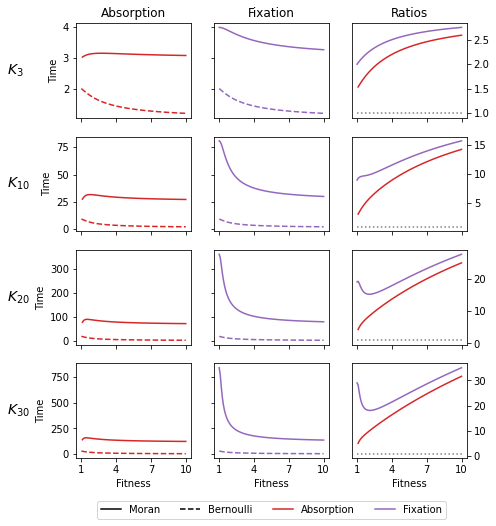

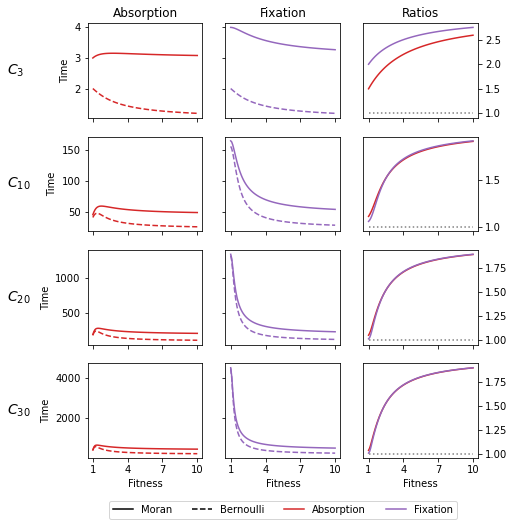

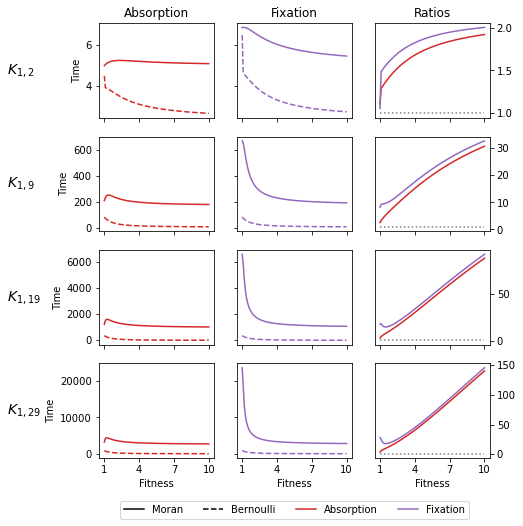

In [22]:
for name in ["complete", "cycle", "star"]:
    fig, axss = plt.subplots(nrows=4, ncols=3, sharex=True, figsize=(7,8))
        
    for axs, N in zip(axss, Ns):
        DAT = getattr(DATOS[N], name)
        
        label = f"$K_{{{N}}}$" if name=="complete" else f"$C_{{{N}}}$" if name=="cycle" else f"$K_{{1,{N-1}}}$"
        left = -0.6 if name=="complete" else -0.7 if name=="cycle" else -0.8
        axs[0].text(left, 0.5, label, transform=axs[0].transAxes,
                fontsize=14, va='center')

        axs[0].plot(rs, DAT.M.absorption, c=colorcycle[3])
        axs[0].plot(rs, DAT.B.absorption, "--", c=colorcycle[3])

        axs[1].plot(rs, DAT.M.fixation, c=colorcycle[4])
        axs[1].plot(rs, DAT.B.fixation, "--", c=colorcycle[4])

        axs[0].get_shared_y_axes().join(*axs[:2])
        axs[1].set_yticklabels([])

        axs[2].plot(rs, np.array(DAT.M.absorption) / np.array(DAT.B.absorption), c=colorcycle[3])
        axs[2].plot(rs, np.array(DAT.M.fixation) / np.array(DAT.B.fixation), c=colorcycle[4])
        axs[2].plot(rs, [1]*len(rs), linestyle="dotted", c="gray")
        axs[2].yaxis.tick_right()

    axss[0,0].set_xticks(np.arange(1,11,3))
    axss[0,0].set_title("Absorption")
    axss[0,1].set_title("Fixation")
    axss[0,2].set_title("Ratios")

    for ax in axss[-1]:
        ax.set_xlabel("Fitness")
    for ax in axss[:,0]:
        ax.set_ylabel("Time")

    axss[-1,1].plot([np.nan], [np.nan], c="k", label="Moran")
    axss[-1,1].plot([np.nan], [np.nan], "--", c="k", label="Bernoulli")
    axss[-1,1].plot([np.nan], [np.nan], c=colorcycle[3], label="Absorption")
    axss[-1,1].plot([np.nan], [np.nan], c=colorcycle[4], label="Fixation")

    axss[-1,1].legend(loc='upper center', 
                 bbox_to_anchor=(0.5, -0.4), shadow=False, ncol=4)
    
    fig.savefig(f"{name}.pdf", bbox_inches="tight")
    del fig

#### Definitivo

In [23]:
import matplotlib.gridspec as gridspec
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import itertools as it


In [24]:
with open("DATOS3.pickle", "rb") as infile:
    DATOS = pickle.load(infile)
rs = np.linspace(0,5,100)[1:]

In [25]:
DATOS[3].complete

In [26]:
# Color codes
moran_color = "tab:blue"
bernoulli_color = "tab:red"
binomial_color = "tab:orange"

In [27]:
for name in ["complete", "cycle", "star"]:
    for N in [3,10,20,30]:
        DAT = getattr(DATOS[N], name)

        fig,axs = plt.subplots(1, 2, figsize=(6,2.75), sharex=True, sharey=True)
        
        for ax, ty in zip(axs, ["absorption", "fixation"]):
            ax.plot(rs, getattr(DAT.M, ty), label="Moran", c=moran_color)
            ax.plot(rs, getattr(DAT.B, ty), label="Bernoulli w/ $p_c$", c=bernoulli_color)
            ax.set_xlabel("Fitness")
            
            if name == "complete":
                fname = "K"
                gtitle = f"{ty.capitalize()} time on $K_{{{N}}}$"
            elif name == "cycle":
                fname = "C"
                gtitle = f"{ty.capitalize()} time on $C_{{{N}}}$"
            elif name == "star":
                fname = "S"
                gtitle = f"{ty.capitalize()} time on $K_{{1,{N-1}}}$"
            ax.set_title(gtitle)
        
        axs[0].legend()
        axs[0].set_ylabel("Mean time")
        plt.tight_layout()
        
        plt.savefig(f"{fname}{N}.pdf", bbox_inches="tight")
        plt.close()


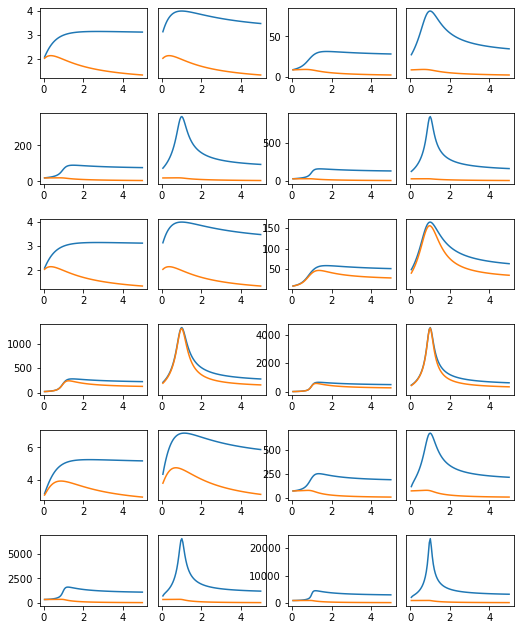

In [24]:
fig = plt.figure(figsize=(8.5,11))

gs = gridspec.GridSpec(6, 2, figure=fig, hspace=0.5, wspace=0.1)
gaxs = np.empty((6,4), dtype=object)
for row in range(6):
    for col in range(2):
        gsp = gridspec.GridSpecFromSubplotSpec(1,2, subplot_spec=gs[row, col], hspace=0.03, wspace=0.1)
        ax1 = fig.add_subplot(gsp[0])
        ax2 = fig.add_subplot(gsp[1])
        gaxs[row, 2*col] = ax1
        gaxs[row, 2*col+1] = ax2
        ax1.get_shared_x_axes().join(ax1,ax2)
        ax1.get_shared_y_axes().join(ax1,ax2)
        ax2.set_yticks([])

for ax, (name, N, ty) in zip(gaxs.flat, 
                             it.product(
                                 ["complete", "cycle", "star"], DATOS, ["absorption", "fixation"]
                             )):
    DAT = getattr(DATOS[N], name)
    ax.plot(rs, getattr(DAT.M, ty))
    ax.plot(rs, getattr(DAT.B, ty))

    


In [8]:
DATOS

{3: <__main__.DAT_t at 0x7f6b73946ef0>,
 10: <__main__.DAT_t at 0x7f6ae288d9c0>,
 20: <__main__.DAT_t at 0x7f6ae28d7a30>,
 30: <__main__.DAT_t at 0x7f6ae2669ae0>}

In [ ]:
for col, tripos, varname in zip(range(2), 
              [[1,2], [22,23]],
              "xy"):
    for row,l in enumerate([1.0,1.1,1.2,1.3]):
        axs = gaxs[2*row:2*(row+1),col]
        for i,x in enumerate(fts[l]):
            #plt.plot([i]*len(x), [a[tripos].mean() for a in x], '.', c="k", alpha=.05)
            for t,color in zip(tripos,["red", "blue"]):
                tmp = set([a[t] for a in fps[l][i]])
                axs[0].plot([i]*len(tmp), list(tmp), '.', c=color)
                #axs[0].plot([i]*len(fps[l][i]), fts[l][i], '.', c="g", alpha=.05)
                #axs[0].plot([i]*len(fps[l][i]), ft2s[l][i], '.', c="g", alpha=.05)
            tmp = set(np.round(ft2s[l][i], 3))
            axs[0].plot([i]*len(tmp), list(tmp), '.', c="g")
        axs[0].set_xlim([0,200])
        #axs[0].set_ylim([0,1])
        axs[0].set_xticks([])
        #axs[0].set_yticks([])
        img = plt.imread(f"{str(l).replace('.', '')}.png")
        axs[1].imshow(img, aspect="auto")
        axs[1].set_xticks([])
    #plt.savefig(f"{l}-sync-y.pdf")
    #plt.close("all")

#gaxs[0,0].get_shared_x_axes().join(*(gaxs[:,:].flatten()))
#gaxs[0,0].get_shared_y_axes().join(*(gaxs[::2,:].flatten()))
#for row in gaxs[::2]:
#    row[0].get_shared_y_axes().join(*row)

for ax in gaxs[::2,-1]:
    ax.set_yticks([])
for ax in gaxs[1::2,0]:
    ax.set_yticks([])

for ax in gaxs[-1]:
    a,b = ax.get_xlim()
    ax.set_xticks([0,b/2,b])
    ax.set_xticklabels([5,5.5,6])
    ax.set_xlabel("$B$")

for l,ax in zip([1.0,1.1,1.2,1.3], gaxs[1::2,-1]):
    ax.yaxis.tick_right()    
    ax.set_yticks(ax.get_ylim())
    ax.set_ylabel("$\lambda_1$")
    ax.yaxis.set_label_position("right")
    ax.set_yticklabels(reversed([l,np.round(l-0.1,1)]))


for ax in gaxs[::2,0]:
    ax.set_ylabel(r"$\beta_{0.05}$")

gaxs[0,0].set_title(r"$\beta_{0.05}$ for $x$ variables")
gaxs[0,1].set_title(r"$\beta_{0.05}$ for $y$ variables")

gaxs[7,1].plot([],[],'.', c="red", label=r"$y_1$ vs $y_2$")
gaxs[7,1].plot([],[],'.', c="blue", label=r"$y_1$ vs $y_3$")
gaxs[7,1].plot([],[],'.', c="green", label="Aperiodicity")
gaxs[7,1].legend(bbox_to_anchor=(0, -0.7, 1, -0.5), mode="expand", ncol=3, 
                 loc="upper left", handlelength=1, handletextpad=0.2) 
gaxs[7,0].plot([],[],'.', c="red", label=r"$x_1$ vs $x_2$")
gaxs[7,0].plot([],[],'.', c="blue", label=r"$x_1$ vs $x_3$")
gaxs[7,0].plot([],[],'.', c="green", label="Aperiodicity")
gaxs[7,0].legend(bbox_to_anchor=(0, -0.7, 1, -0.5), mode="expand", ncol=3, 
                 loc="upper left", handlelength=1, handletextpad=0.2) 

cax = plt.axes([.3, .02, .4, 0.01])
cmappable = ScalarMappable(Normalize(0,8), cmap="jet")
cbar = plt.colorbar(cax=cax, mappable=cmappable,orientation="horizontal")
cbar.ax.set_xlabel('Spike counting', position=(1,0))
#cbar.ax.yaxis.set_label_position("right")

fig.savefig("sync_between_vars.pdf", bbox_inches="tight", pad_inches=0)

#### plt.plot(rs, DATOS[30].star.M.absorption, c=colorcycle[2])